# 6-7. 프로젝트: 멋진 작사가 만들기

<br>

### 라이브러리 버전을 확인해 봅니다

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.6.0


<br>

## 1. 데이터 읽어오기

`glob` 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. `glob` 를 활용하여 모든 `txt` 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장하도록 할게요!

### 노래 가사 개수 및 문장 총 개수 확인

In [2]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다.
# txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
txt_file_path = os.getenv('HOME')+'/aiffel/Exploration-6/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) # txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines() : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("노래 가사 총 개수:", len(txt_list))
print("문장 총 개수:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])

노래 가사 총 개수: 49
문장 총 개수: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth']


<br>

## 2. 데이터 정제

###  원하는 데이터만 추출하기
* 49개의 노래가사 데이터에서 필요한 문장은 각각의 가사 부분이다. 그러므로 다음과 같이 불필요한 부분은 제거해준다.
* 아래는 제거를 위한 기준이다.

#### 1. 가사와 가사간의 공백인 문장
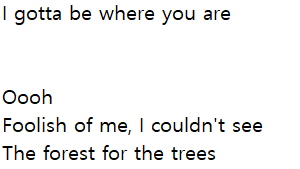

#### 2. 가사가 중복되는 문장
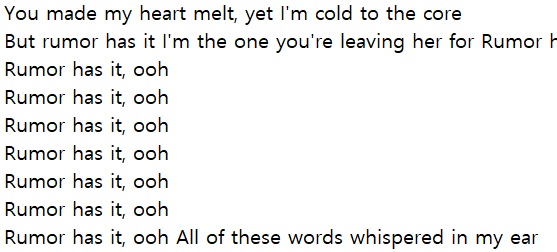

#### 3. 가사의 x절이 포함된부분, 가수의 파트를 위해 포함된 부분
* 가사의 1절, 2절을 구분하기위해 대괄호가 존재. 이는 불필요한 요소라 생각하기 때문에 제거.
* 가수들의 파트를 나누는 부분 및 chorus, 호응유도 등을 구분하기위해 대괄호가 존재. 마찬가지로 불필요한 요소.

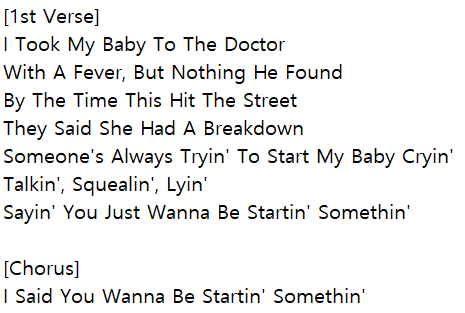

* 위의 작업을 진행시 corpus 리스트를 만들어서 각 문장마다 정제후 리스트에 바로 담는다.
* 또한 리스트에 공백, 대괄호가 포함된 문장이 제외되었을 것 이지만 중복된 문장이 존재할 것 이므로 세트(set)의 중복불가 특성을 이용하여 정제해준다.

In [3]:
corpus = [] # 미리 정제된 문장들을 담을 corpus

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue         # 길이가 0인 문장은 건너뛰기.
    if ('[' and ']') in sentence: continue  # 대괄호가 들어가는 문장 제외.
    if sentence[-1] == ":": continue        # 문장의 끝이 : 인 문장은 건너뛰기.

    corpus.append(sentence)

print(f"raw_corpus의 문장 총 개수 : ", len(raw_corpus))
print(f'공백인 문장, 대괄호 들어간 문장 삭제한 데이터 개수 : {len(corpus)}')

corpus = list(set(corpus))    # 중복불가한 set의 특성을 이용. 중복제거후 다시 corpus리스트로 변환.
print(f'중복문장 제외한 문장 총 크기 : {len(corpus)}')

raw_corpus의 문장 총 개수 :  187088
공백인 문장, 대괄호 들어간 문장 삭제한 데이터 개수 : 174209
중복문장 제외한 문장 총 크기 : 116907


### preprocess_sentence(sentence):
* 이 함수의 목적은 문장을 기준에 따라 정제하여 토큰화(Tokenize)해준다.

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 , 끝에는 공백을 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    
    return sentence

In [5]:
corpus_tokenized = []

for sentence in corpus:
    # 토큰화(전처리) 함수 호출
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_tokenized.append(preprocessed_sentence)
        
print("문장 총 개수:", len(corpus_tokenized))

# random으로 문장 확인
random.sample(corpus_tokenized, 20)

문장 총 개수: 116907


['<start> this is how they play the game <end>',
 '<start> and before us animosity will stand and decree <end>',
 '<start> but victory s contagious no one round here s good at keeping their eyes closed <end>',
 '<start> give head stop breathe get up check your weave <end>',
 '<start> for now we ll make a vow <end>',
 '<start> that s why i asked you how you mean , how you mean <end>',
 '<start> towering over your head <end>',
 '<start> working hard to perfect it <end>',
 '<start> you can almost think that you re seein double <end>',
 '<start> the beckoning sea <end>',
 '<start> you shake your a around for everyone <end>',
 '<start> make some with you <end>',
 '<start> and she got the goods <end>',
 '<start> think about life , i d like to have my child <end>',
 '<start> dont fill them clips too high give them bullets room to breathe <end>',
 '<start> but now i see you messing me around <end>',
 '<start> can u tell me where we re going ? <end>',
 '<start> now i m rapping on the radio , in

<br>

## 3. 토큰화 및 벡터화

* `tf.keras.preprocessing.text.Tokenizer` 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줌.
* 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 함.
* 12000 단어를 기억할 수 있는 tokenizer 생성

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 생성
    # 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 ''로 변경
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   

    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus_tokenized)

[[   2   42    7 ...    0    0    0]
 [   2  137    4 ...    0    0    0]
 [   2 7831   19 ...    0    0    0]
 ...
 [   2   80   26 ...    0    0    0]
 [   2  116    4 ...    0    0    0]
 [   2    5  510 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0d19aefa60>


In [7]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형태로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


### 텐서의 길이 및 토큰 확인
* 첫번째 토큰을 확인하니 짧은 문장이 나왔다.
* 하지만 tensor의 길이를 확인하니 347이 나왔다.
* 대부분의 문장에 0이 추가됨.

In [8]:
print(f'tensor의 shape : {tensor.shape}')
print(f'첫번째 tensor\n : {tensor[0]}')
print(f'첫번째 token : {corpus_tokenized[0]}')
print(f'첫번째 token의 길이 : {len(corpus_tokenized[0])}')

tensor의 shape : (116907, 347)
첫번째 tensor
 : [   2   42    7  155   17    9  595 3041    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   

### 각 문장 길이에 대한 distribution check
* 각 텐서에 대해 0이 아닌 개수들을 구하여 시각화 해본다.
* 기본적인 boxplot과 histogram을 출력해본다.

In [9]:
tensor_len_list = []

for tensor_check in tensor:
    count = 0
    for tensor_count in tensor_check:
        if tensor_count != 0:
            count += 1
    
    tensor_len_list.append(count)

<function matplotlib.pyplot.show(close=None, block=None)>

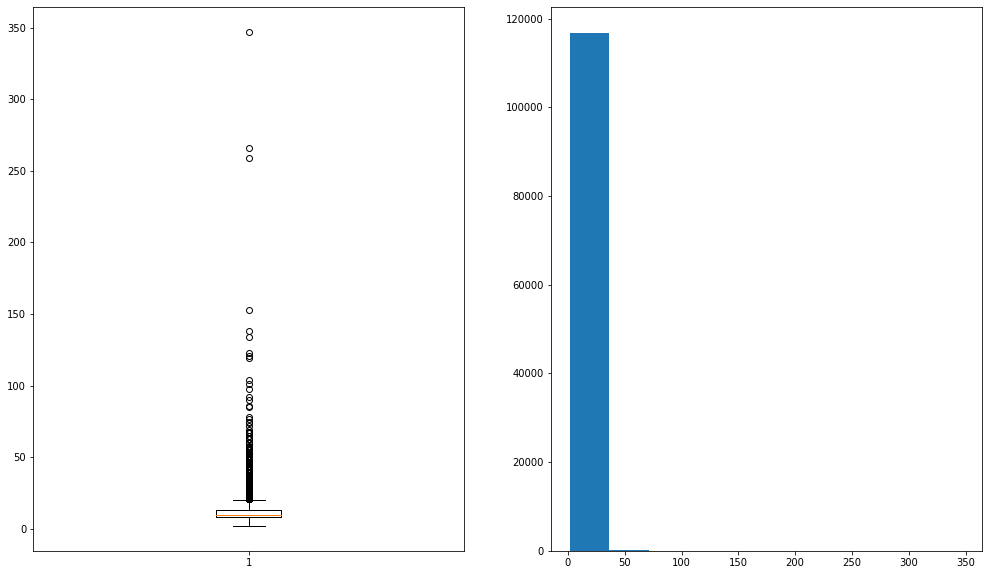

In [10]:
plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
plt.boxplot(tensor_len_list)
plt.subplot(1,2,2)
plt.hist(tensor_len_list)
plt.show

* 위의 boxplot을 보면 분명히 0~100사이 밀집되어 있다. 하지만 이대로는 제대로 확인이 불가하다.

### 각 문장의 길이가 어떤 분포로 구성되어 있는지 시각화
* 각각의 문장에 대해 길이와 그 길이에 해당하는 개수를 구하여 딕셔너리화 한다.

<function matplotlib.pyplot.show(close=None, block=None)>

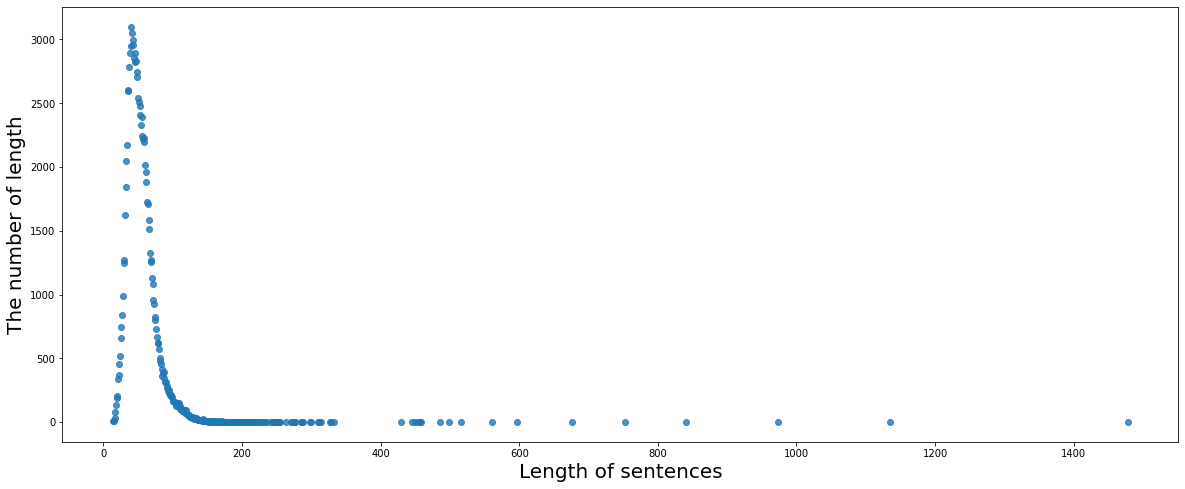

In [11]:
len_dict = {}

for cor in corpus_tokenized:
    if len(cor) in len_dict:
        len_dict[len(cor)] += 1
    else:
        len_dict[len(cor)] = 1        
        
# scatter plot
plt.figure(figsize=(20, 8))
plt.xlabel('Length of sentences', fontsize=20)
plt.ylabel('The number of length', fontsize=20)
plt.scatter(len_dict.keys(), len_dict.values(), alpha=0.8)
plt.show

### scatter plot으로 출력시 분포의 형태가 0에서 약 30사이 집중 포진
* 문장의 길이가 다른 문장에 비해 길기 때문에 행 뒤에 0으로 패딩(padding)이 **비정상적**으로 이루어짐
* 일반적으로 이상치의 기준은 다르지만 현재의 상황에서 볼 때 비정상적으로 긴 문장은 **모델의 성능에 다소 악영향**을 끼칠 것 같다.
* 그러므로 일정 길이 이상의 문장의 개수를 확인해 본다.

In [12]:
corpus_tokenized[0]

'<start> what you call that a million bucks <end>'

In [13]:
# 문장의 길이가 긴 것들을 직접 출력해서 실체를 확인해보자
# 미리 확인한 결과 길이가 200이 넘는 문장은 80개, 150이 넘는 문장은 총 228개가 있다
count = 0
count_100 = 0
count_150 = 0
count_200 = 0
count_250 = 0
dummy = []

for outlier_corpus in corpus_tokenized:
    if len(outlier_corpus) < 100:
        count +=1
    
    if len(outlier_corpus) >= 100:
        count_100 +=1
    
    if len(outlier_corpus) >= 150:
        count_150 +=1
    
    if len(outlier_corpus) >= 200:
        count_200 +=1
    
    if len(outlier_corpus) >= 250:
        count_250 +=1

print("문장의 길이가 100 미만인 sentence의 개수:", count)
print("문장의 길이가 100 이상인 sentence의 개수:", count_100)
print("문장의 길이가 150 이상인 sentence의 개수:", count_150)
print("문장의 길이가 200 이상인 sentence의 개수:", count_200)
print("문장의 길이가 250 이상인 sentence의 개수:", count_250)

for index, outlier_corpus in enumerate(corpus_tokenized):
    if len(outlier_corpus) >= 250:
        print(outlier_corpus)
    
    if index == 20000 :
        break

문장의 길이가 100 미만인 sentence의 개수: 113337
문장의 길이가 100 이상인 sentence의 개수: 3570
문장의 길이가 150 이상인 sentence의 개수: 237
문장의 길이가 200 이상인 sentence의 개수: 80
문장의 길이가 250 이상인 sentence의 개수: 40
<start> i ve never been so lonesome in my life as i am right now . i m completely lost without you , darling . i never realized i could miss any one person so much . i just hope it won t be too much longer until i m able to be with you again . . . and live a sane and normal life . i m sick of always hearing <end>
<start> and besides you need this you know how church folk can be boy i m your sister , trust in me mm now hold on maybe she s gone no maybe we ought to just try . . . hello shh shh , hello , is kim there ? yes , i think she s around here somewhere <end>
<start> writers russell brown , irwin levine i m comin home , i ve done my time now i ve got to know what is and isn t mine if you received my letter telling you i d soon be free then you ll know just what to do if you still want me if you still want me just

### 문장의 길이 확인 결과
* 문장의 길이가 100 미만인 sentence의 개수: 113337
* 문장의 길이가 100 이상인 sentence의 개수: 3570
* 문장의 길이가 150 이상인 sentence의 개수: 237
* 문장의 길이가 200 이상인 sentence의 개수: 80
* 문장의 길이가 250 이상인 sentence의 개수: 40

#### 실제 문장의 길이가 100미만 개수의 비율은 96.65% 이고,문장의 길이가 150미만인 개수의 비율은 99.7% 이므로 확률분포측면에서 보았을때 분포의 설명력이 좋다.

#### 나머지 150이상의 문장들은 불필요하다 라고는 말 할수 없지만 모델의 입장에서는 그지 좋은선택은 아닌 것 같으므로, 문장의 길이가 150 이상인 문장들은 제거한다.

* 이후 제거된 문장으로 다시 토큰화를 진행.

In [14]:
# 문장 길이가 150 이상인 문장들은 제거

final_corpus_tokenized = []
count = 0

for cor in corpus_tokenized:
    if len(cor) < 150:
        final_corpus_tokenized.append(cor)
    else:
        count += 1
        
print("삭제한 문장 개수: ", count)
print("최종 문장 개수:", len(final_corpus_tokenized))

삭제한 문장 개수:  237
최종 문장 개수: 116670


In [15]:
# final_corpus_tokenized를 이용해 재(re) 토큰화
tensor, tokenizer = tokenize(final_corpus_tokenized)

print(f'tensor의 shape : {tensor.shape}')
print(f'첫번째 tensor\n : {tensor[0]}')
print(f'첫번째 token : {corpus_tokenized[0]}')
print(f'첫번째 token의 길이 : {len(corpus_tokenized[0])}')

[[   2   42    7 ...    0    0    0]
 [   2  137    4 ...    0    0    0]
 [   2 7796   20 ...    0    0    0]
 ...
 [   2   80   26 ...    0    0    0]
 [   2  120    4 ...    0    0    0]
 [   2    5  515 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0d17227e20>
tensor의 shape : (116670, 39)
첫번째 tensor
 : [   2   42    7  155   17    9  592 3022    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
첫번째 token : <start> what you call that a million bucks <end>
첫번째 token의 길이 : 48


<br>

## 4. 텐서를 source 와 target 분리

* 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 진행
* 텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것.

In [16]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 가 아니라 일 가능성이 높습니다.
src_input = tensor[:, :-1]

# tensor에서 를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   42    7  155   17    9  592 3022    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  42    7  155   17    9  592 3022    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


<br>

## 5.데이터셋 객체를 생성
* tf.data.Dataset객체를 생성하는 방법 사용
* tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성.

In [17]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 38), (256, 38)), types: (tf.int32, tf.int32)>

<br>

## 6. 모델 구성

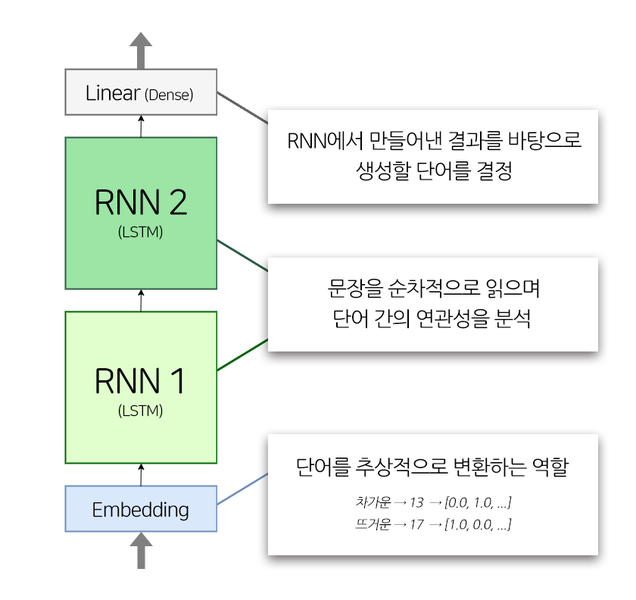

In [18]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

<br>

## 7. Validation 데이터셋 분리

* 전체 중 20%를 validation을 위해 분리

In [19]:
# 전체 중 20%를 validation을 위한 데이터셋으로 분리
src_train, src_val, tgt_train, tgt_val = train_test_split(
    src_input, tgt_input,
    test_size=0.2,
    random_state=35
)

# 각 데이터셋 사이즈 확인
print("Source train: ", src_train.shape)
print("Target train: ", tgt_train.shape)
print("Source validation: ", src_val.shape)
print("Target validation: ", tgt_val.shape)

Source train:  (93336, 38)
Target train:  (93336, 38)
Source validation:  (23334, 38)
Target validation:  (23334, 38)


<br>

## 8. 모델 학습

In [20]:
# optimizer와 loss등은 차차 배웁니다 
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
History = model.fit(src_train, tgt_train, validation_data=(src_val, tgt_val), batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
365/365 [==============================] - 193s 513ms/step - loss: 1.7285 - val_loss: 1.4454
Epoch 2/10
365/365 [==============================] - 189s 518ms/step - loss: 1.3936 - val_loss: 1.3655
Epoch 3/10
365/365 [==============================] - 189s 519ms/step - loss: 1.3269 - val_loss: 1.3152
Epoch 4/10
365/365 [==============================] - 190s 519ms/step - loss: 1.2797 - val_loss: 1.2853
Epoch 5/10
365/365 [==============================] - 190s 521ms/step - loss: 1.2442 - val_loss: 1.2655
Epoch 6/10
365/365 [==============================] - 190s 520ms/step - loss: 1.2137 - val_loss: 1.2491
Epoch 7/10
365/365 [==============================] - 190s 520ms/step - loss: 1.1859 - val_loss: 1.2368
Epoch 8/10
365/365 [==============================] - 190s 521ms/step - loss: 1.1592 - val_loss: 1.2264
Epoch 9/10
365/365 [==============================] - 191s 523ms/step - loss: 1.1334 - val_loss: 1.2194
Epoch 10/10
365/365 [==============================] - 190s 521m

<br>

## 9. 모델평가

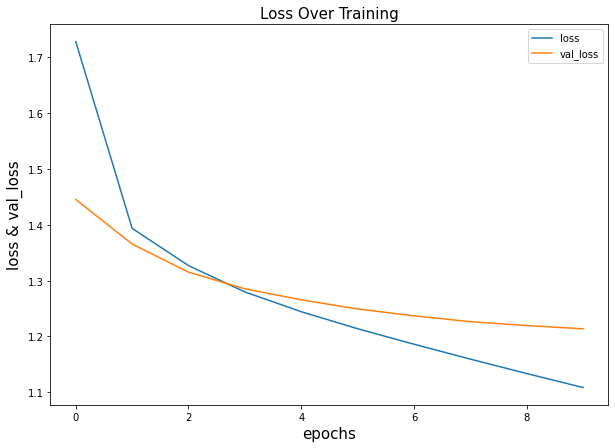

In [21]:
fig = plt.figure(figsize=(10, 7))

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])

plt.title('Loss Over Training', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss & val_loss', fontsize=15)
plt.legend(['loss','val_loss'])

plt.show()

<br>

## 10. 잘 만들어졌는지 평가하기

In [22]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [23]:
generate_text(model, tokenizer, init_sentence="<start> why")

'<start> why you think i m a <unk> <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> you")

'<start> you re the only one <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> yesterday")

'<start> yesterday is a <unk> <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> love")

'<start> love is a little bit of the <unk> <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> what")

'<start> what you want to do <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> do")

'<start> do you think i m a <unk> <end> '

In [29]:
generate_text(model, tokenizer, init_sentence="<start> i really")

'<start> i really want to be a <unk> <end> '

In [30]:
generate_text(model, tokenizer, init_sentence="<start> how")

'<start> how many times i ve been through <end> '

In [31]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you , i m a <unk> <end> '